In [10]:
import pandas as pd
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

# ------------------------------
# 1. Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
good_metals = ["Pd", "Pt", "Rh", "Ni", "Cu", "Fe", "Ru", "Ir", "Zn"]

# ------------------------------
# 2. Load & Label Data
# ------------------------------
df = pd.read_csv("cleaned_mapped_reactions.csv").dropna(subset=["Mapped_Reactants", "Mapped_Products", "Catalyst"])
df = df.sample(n=20000, random_state=42)

def is_good_catalyst(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            return 0
        for atom in mol.GetAtoms():
            if atom.GetSymbol() in good_metals:
                return 1
        return 0
    except:
        return 0

df["Suitability"] = df["Catalyst"].apply(is_good_catalyst)
print(df["Suitability"].value_counts())

# ------------------------------
# 3. Molecule to Graph
# ------------------------------
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atom_feats, edge_index, edge_attr = [], [], []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        bond_feats = [
            float(bond.GetBondTypeAsDouble()),
            int(bond.GetIsAromatic()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_attr += [bond_feats, bond_feats]
    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def combined_graph(reactant, product, catalyst):
    r, p, c = mol_to_graph(reactant), mol_to_graph(product), mol_to_graph(catalyst)
    if None in (r, p, c):
        return None
    offset_p = r.x.size(0)
    offset_c = offset_p + p.x.size(0)
    p.edge_index += offset_p
    c.edge_index += offset_c
    x = torch.cat([r.x, p.x, c.x], dim=0)
    edge_index = torch.cat([r.edge_index, p.edge_index, c.edge_index], dim=1)
    edge_attr = torch.cat([r.edge_attr, p.edge_attr, c.edge_attr], dim=0)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# ------------------------------
# 4. Dataset Class
# ------------------------------
class CatalystClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.graphs = []
        self.labels = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            graph = combined_graph(row["Mapped_Reactants"], row["Mapped_Products"], row["Catalyst"])
            if graph is not None:
                graph.y = torch.tensor([row["Suitability"]], dtype=torch.float)
                self.graphs.append(graph)
                self.labels.append(row["Suitability"])

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

# ------------------------------
# 5. Model
# ------------------------------
class CatalystSuitabilityClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        node_input_dim = 5
        edge_input_dim = 4
        hidden_dim = 64

        self.gnn = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ),
            edge_dim=edge_input_dim  # ✅ Important!
        )

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_attr)
        pooled = global_mean_pool(x, batch=data.batch)
        return self.mlp(pooled)


# ------------------------------
# 6. Training
# ------------------------------
from torch_geometric.loader import DataLoader

dataset = CatalystClassifierDataset(df)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = CatalystSuitabilityClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

print("🔥 Training started...")
for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch).squeeze()
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    avg_loss = total_loss / len(loader.dataset)
    print(f"📚 Epoch {epoch:02d} | Loss: {avg_loss:.4f}")

# ------------------------------
# 7. Save Model
# ------------------------------
torch.save(model.state_dict(), "suitability_classifier.pt")
print("✅ Model saved as suitability_classifier.pt")


Suitability
0    18033
1     1967
Name: count, dtype: int64


[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not removing hydrogen atom without neighbors
[07:05:50] WARNING: not r

🔥 Training started...
📚 Epoch 01 | Loss: 0.3103
📚 Epoch 02 | Loss: 0.2193
📚 Epoch 03 | Loss: 0.1551
📚 Epoch 04 | Loss: 0.1340
📚 Epoch 05 | Loss: 0.1175
✅ Model saved as suitability_classifier.pt


In [12]:
import pandas as pd
import torch
import torch.nn as nn
from rdkit import Chem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool
from tqdm import tqdm

# ✅ Environment setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
good_metals = ["Pd", "Pt", "Rh", "Ni", "Cu", "Fe", "Ru", "Ir", "Zn"]

# ✅ Load your existing file
df = pd.read_csv("cleaned_mapped_reactions.csv")
df = df.dropna(subset=["Mapped_Reactants", "Mapped_Products", "Catalyst"])
df = df.sample(n=20000, random_state=42)

# ✅ Assign suitability label
def is_good_catalyst(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol: return 0
        return int(any(atom.GetSymbol() in good_metals for atom in mol.GetAtoms()))
    except: return 0

df["Suitability"] = df["Catalyst"].apply(is_good_catalyst)
print(df["Suitability"].value_counts())

# ✅ Molecule to graph
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atom_feats, edge_index, edge_attr = [], [], []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        bond_feats = [
            float(bond.GetBondTypeAsDouble()),
            int(bond.GetIsAromatic()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_attr += [bond_feats, bond_feats]
    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# ✅ Dataset
class CatalystClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.graphs = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            graph = mol_to_graph(row["Catalyst"])
            if graph is not None:
                graph.y = torch.tensor([row["Suitability"]], dtype=torch.float)
                self.graphs.append(graph)
    def __len__(self): return len(self.graphs)
    def __getitem__(self, idx): return self.graphs[idx]

# ✅ Model
class CatalystSuitabilityClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        node_input_dim = 5
        edge_input_dim = 4
        hidden_dim = 64
        self.gnn = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ),
            edge_dim=edge_input_dim
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_attr)
        pooled = global_mean_pool(x, batch=data.batch)
        return self.mlp(pooled)

# ✅ Train
dataset = CatalystClassifierDataset(df)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = CatalystSuitabilityClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

print("🔥 Training started...")
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch).squeeze()
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    print(f"📚 Epoch {epoch+1:02d} | Loss: {total_loss / len(loader.dataset):.4f}")

torch.save(model.state_dict(), "suitability_classifier.pt")
print("✅ Saved model as suitability_classifier.pt")


Suitability
0    18033
1     1967
Name: count, dtype: int64


100%|██████████| 20000/20000 [00:05<00:00, 3557.22it/s]


🔥 Training started...
📚 Epoch 01 | Loss: 0.1492
📚 Epoch 02 | Loss: 0.0347
📚 Epoch 03 | Loss: 0.0243
📚 Epoch 04 | Loss: 0.0214
📚 Epoch 05 | Loss: 0.0195
✅ Saved model as suitability_classifier.pt


In [13]:
import torch
import torch.nn as nn
from torch_geometric.nn import GINEConv, global_mean_pool
from rdkit import Chem
from torch_geometric.data import Data

# ✅ Use the same mol_to_graph function from before
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atom_feats, edge_index, edge_attr = [], [], []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feats = [
            float(bond.GetBondTypeAsDouble()),
            int(bond.GetIsAromatic()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_feats, bond_feats]
    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# ✅ Model (must match the saved one)
class CatalystSuitabilityClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        node_input_dim = 5
        edge_input_dim = 4
        hidden_dim = 64

        self.gnn = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ),
            edge_dim=edge_input_dim
        )

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_attr)
        pooled = global_mean_pool(x, batch=data.batch)
        return self.mlp(pooled)

# ✅ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatalystSuitabilityClassifier().to(device)
model.load_state_dict(torch.load("suitability_classifier.pt", map_location=device))
model.eval()

# ✅ Your generated candidates
candidates = [
    "COCCOCOCOCOCOCCOCCCOCCCOCCOCOCOCOCCOCCSCCOCOCOCOOCCCOCOCOOCC",
    "CC=O",
    "CS=O",
    "COCCC=O",
    "OOOOOOOCC(C)O"
]

# ✅ Predict suitability
for i, smiles in enumerate(candidates, 1):
    graph = mol_to_graph(smiles)
    if graph is None:
        print(f"❌ Option {i}: Invalid SMILES")
        continue
    graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)
    graph = graph.to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(graph)).item()
    print(f"✅ Option {i}: {smiles} | Suitability Score: {pred:.4f}")


✅ Option 1: COCCOCOCOCOCOCCOCCCOCCCOCCOCOCOCOCCOCCSCCOCOCOCOOCCCOCOCOOCC | Suitability Score: 0.0000
✅ Option 2: CC=O | Suitability Score: 0.0000
✅ Option 3: CS=O | Suitability Score: 0.0000
✅ Option 4: COCCC=O | Suitability Score: 0.0000
✅ Option 5: OOOOOOOCC(C)O | Suitability Score: 0.0000


In [15]:
!pip install seaborn

100%|██████████| 4000/4000 [00:01<00:00, 3897.45it/s]



📊 Classification Report:
              precision    recall  f1-score   support

Not Suitable       1.00      1.00      1.00      3607
    Suitable       0.97      0.99      0.98       393

    accuracy                           1.00      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



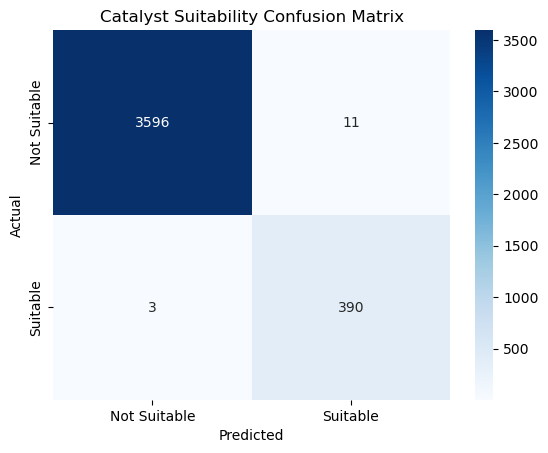

In [16]:
# ✅ Catalyst Suitability Classifier Evaluation (Phase 2A)
# This code adds model evaluation to your already trained model.

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------
# 1. Load Trained Model
# -------------------------
model = CatalystSuitabilityClassifier().to(device)
model.load_state_dict(torch.load("suitability_classifier.pt", map_location=device))
model.eval()

# -------------------------
# 2. Create Train/Test Split
# -------------------------
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Suitability"], random_state=42)

train_dataset = CatalystClassifierDataset(train_df)
test_dataset = CatalystClassifierDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -------------------------
# 3. Evaluate Model
# -------------------------
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch).squeeze()
        probs = torch.sigmoid(out)
        preds = (probs > 0.5).long().cpu().numpy()
        labels = batch.y.long().cpu().numpy()
        y_true.extend(labels)
        y_pred.extend(preds)

# -------------------------
# 4. Metrics + Confusion Matrix
# -------------------------
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Not Suitable", "Suitable"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Suitable", "Suitable"], yticklabels=["Not Suitable", "Suitable"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Catalyst Suitability Confusion Matrix")
plt.show()


In [17]:
from rdkit import Chem
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINEConv, global_mean_pool
import torch.nn as nn

# ------------------------
# Load Trained Classifier
# ------------------------
class CatalystSuitabilityClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        node_input_dim = 5
        edge_input_dim = 4
        hidden_dim = 64

        self.gnn = GINEConv(
            nn=nn.Sequential(
                nn.Linear(node_input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ),
            edge_dim=edge_input_dim
        )

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_attr)
        pooled = global_mean_pool(x, batch=data.batch)
        return self.mlp(pooled)

# ✅ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatalystSuitabilityClassifier().to(device)
model.load_state_dict(torch.load("suitability_classifier.pt", map_location=device))
model.eval()

# ------------------------
# Catalyst Evaluation
# ------------------------
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atom_feats, edge_index, edge_attr = [], [], []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        bond_feats = [
            float(bond.GetBondTypeAsDouble()),
            int(bond.GetIsAromatic()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_attr += [bond_feats, bond_feats]
    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def evaluate_generated_candidates(smiles_list):
    results = []
    for s in smiles_list:
        graph = mol_to_graph(s)
        if graph is None:
            results.append((s, 0.0))  # Invalid SMILES
            continue
        graph = graph.to(device)
        with torch.no_grad():
            score = torch.sigmoid(model(graph)).item()
        results.append((s, score))
    results.sort(key=lambda x: x[1], reverse=True)
    return results


In [18]:
generated_smiles = [
    "COCCOCOCOCOCOCCOCCCOCCCOCCOCOCOCOCCOCCSCCOCOCOCOOCCCOCOCOOCC",
    "CC=O",
    "CS=O",
    "COCCC=O",
    "OOOOOOOCC(C)O"
]

ranked = evaluate_generated_candidates(generated_smiles)
for i, (smi, score) in enumerate(ranked, 1):
    print(f"✅ Option {i}: {smi} | Suitability Score: {score:.4f}")


✅ Option 1: CC=O | Suitability Score: 0.0000
✅ Option 2: CS=O | Suitability Score: 0.0000
✅ Option 3: COCCC=O | Suitability Score: 0.0000
✅ Option 4: OOOOOOOCC(C)O | Suitability Score: 0.0000
✅ Option 5: COCCOCOCOCOCOCCOCCCOCCCOCCOCOCOCOCCOCCSCCOCOCOCOOCCCOCOCOOCC | Suitability Score: 0.0000


In [19]:
# Load and filter to good catalysts
df = pd.read_csv("cleaned_mapped_reactions.csv").dropna(subset=["Mapped_Reactants", "Mapped_Products", "Catalyst"])

# Same metal filter logic
good_metals = {"Pd", "Pt", "Rh", "Ni", "Cu", "Fe", "Ru", "Ir", "Zn"}
def is_good_catalyst(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return int(any(atom.GetSymbol() in good_metals for atom in mol.GetAtoms()))
    except:
        return 0

df["Suitability"] = df["Catalyst"].apply(is_good_catalyst)

# Filter to only positive catalysts
df_good = df[df["Suitability"] == 1].copy()
df_good = df_good.sample(n=min(10000, len(df_good)), random_state=42)  # smaller set

print("✅ Filtered good catalysts:", len(df_good))
df_good.to_csv("positive_catalysts.csv", index=False)


✅ Filtered good catalysts: 10000


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool
from rdkit import Chem
from tqdm import tqdm
import selfies as sf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load filtered positive dataset
df = pd.read_csv("positive_catalysts.csv").dropna(subset=["Mapped_Reactants", "Mapped_Products", "Catalyst"])

# ✅ SELFIES Tokenizer
def build_selfies_tokenizer(smiles_list):
    charset = set()
    for smi in smiles_list:
        try:
            tokens = list(sf.split_selfies(sf.encoder(smi)))
            charset.update(tokens)
        except:
            continue
    tokens = sorted(charset)
    stoi = {t: i+4 for i, t in enumerate(tokens)}
    stoi['<pad>'] = 0
    stoi['<bos>'] = 1
    stoi['<eos>'] = 2
    stoi['<unk>'] = 3
    itos = {i: s for s, i in stoi.items()}
    return stoi, itos

# ✅ Molecule to Graph
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atom_feats, edge_index, edge_attr = [], [], []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        edge_attr += [[
            float(bond.GetBondTypeAsDouble()),
            int(bond.GetIsAromatic()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]] * 2
    return Data(
        x=torch.tensor(atom_feats, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long).T.contiguous(),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float)
    )

# ✅ Build graph and sequence dataset
graphs, smiles = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    g = mol_to_graph(row["Mapped_Reactants"] + row["Mapped_Products"])
    if g:
        graphs.append(g)
        smiles.append(row["Catalyst"])

stoi, itos = build_selfies_tokenizer(smiles)
max_len = max(len(list(sf.split_selfies(sf.encoder(s)))) for s in smiles) + 2


def tokenize_selfies(smiles_list, stoi, max_len):
    tokens = []
    for smi in smiles_list:
        try:
            seq = ['<bos>'] + list(sf.split_selfies(sf.encoder(smi))) + ['<eos>']
            idxs = [stoi.get(t, stoi['<unk>']) for t in seq]
            idxs = idxs[:max_len] + [stoi['<pad>']] * (max_len - len(idxs))
            tokens.append(idxs)
        except:
            pass
    return torch.tensor(tokens, dtype=torch.long)

encoded = tokenize_selfies(smiles, stoi, max_len)

# ✅ Dataset
class GenDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, seqs):
        self.graphs = graphs
        self.seqs = seqs
    def __len__(self): return len(self.graphs)
    def __getitem__(self, idx): return self.graphs[idx], self.seqs[idx]

dataset = GenDataset(graphs, encoded)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ✅ GNN + Transformer Model
class GraphEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn = GINEConv(nn.Sequential(nn.Linear(5, 64), nn.ReLU(), nn.Linear(64, 64)), edge_dim=4)
    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_attr)
        return global_mean_pool(x, data.batch)

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.transformer = nn.Transformer(hidden_dim, nhead=4, num_encoder_layers=2, num_decoder_layers=2)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, enc, tgt):
        tgt = self.embedding(tgt).permute(1, 0, 2)
        enc = enc.unsqueeze(0).repeat(tgt.size(0), 1, 1)
        out = self.transformer(enc, tgt)
        return self.fc(out.permute(1, 0, 2))

class CatalystGenModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = GraphEncoder()
        self.decoder = TransformerDecoder(vocab_size)
    def forward(self, graph, tgt): return self.decoder(self.encoder(graph), tgt)

# ✅ Train
model = CatalystGenModel(len(stoi)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=stoi['<pad>'])

print("🚀 Starting retraining...")
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in loader:
        g_batch, tgt = batch
        g_batch = g_batch.to(device)
        tgt = tgt.to(device)
        optimizer.zero_grad()
        output = model(g_batch, tgt[:, :-1])
        loss = loss_fn(output.reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📚 Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f}")

torch.save(model.state_dict(), "catalyst_gen_pos_only.pt")
print("✅ Generator retrained and saved as catalyst_gen_pos_only.pt")


[15:46:59] Explicit valence for atom # 49 C, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 29 C, 5, is greater than permitted
[15:46:59] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[15:46:59] Explicit valence for atom # 19 H, 2, is greater than permitted
[15:46:59] Explicit valence for atom # 19 C, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 35 C, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 33 C, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 16 C, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 17 N, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 15 N, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 25 N, 4, is greater than permitted
[15:46:59] Explicit valence for atom # 16 C, 5, is greater than permitted
[15:46:59] Explicit valence for atom # 20 N, 4, is greater than permitted
[15:46:59] Explicit valence for atom # 30 N, 5

🚀 Starting retraining...


In [67]:
import torch
import torch.nn as nn
import pandas as pd
import selfies as sf
from rdkit import Chem
from torch_geometric.data import Data
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.loader import DataLoader
import pickle

# -----------------------------------
# 1. Load Trained Tokenizer
# -----------------------------------
with open("tokenizer.pkl", "rb") as f:
    stoi, itos = pickle.load(f)
vocab_size = len(stoi)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------
# 2. Define Model Components
# -----------------------------------
class GraphEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn = GINEConv(nn.Sequential(nn.Linear(5, 64), nn.ReLU(), nn.Linear(64, 64)), edge_dim=4)
    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_attr)
        return global_mean_pool(x, data.batch)

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.transformer = nn.Transformer(hidden_dim, nhead=4, num_encoder_layers=2, num_decoder_layers=2)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, enc_out, tgt):
        tgt_emb = self.embedding(tgt).permute(1, 0, 2)  # [T, B, H]
        enc_out = enc_out.unsqueeze(1).repeat(1, tgt_emb.size(0), 1).permute(1, 0, 2)  # [T, B, H]
        out = self.transformer(enc_out, tgt_emb)
        return self.fc(out.permute(1, 0, 2))  # [B, T, V]

class CatalystGenModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = GraphEncoder()
        self.decoder = TransformerDecoder(vocab_size)
    def forward(self, graph, tgt): return self.decoder(self.encoder(graph), tgt)

class CatalystSuitabilityClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn = GINEConv(nn.Sequential(nn.Linear(5, 64), nn.ReLU(), nn.Linear(64, 64)), edge_dim=4)
        self.mlp = nn.Sequential(nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1))
    def forward(self, data):
        x = self.gnn(data.x, data.edge_index, data.edge_attr)
        pooled = global_mean_pool(x, batch=data.batch)
        return self.mlp(pooled)

# -----------------------------------
# 3. Load Models
# -----------------------------------
gen_model = CatalystGenModel(vocab_size).to(device)
gen_model.load_state_dict(torch.load("catalyst_gen_pos_only.pt", map_location=device))
gen_model.eval()

clf_model = CatalystSuitabilityClassifier().to(device)
clf_model.load_state_dict(torch.load("suitability_classifier.pt", map_location=device))
clf_model.eval()

# -----------------------------------
# 4. Graph Builder for Inference
# -----------------------------------
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    atom_feats, edge_index, edge_attr = [], [], []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        feat = [
            float(bond.GetBondTypeAsDouble()),
            int(bond.GetIsAromatic()),
            int(bond.GetIsConjugated()),
            int(bond.IsInRing())
        ]
        edge_index += [[i, j], [j, i]]
        edge_attr += [feat, feat]
    return Data(
        x=torch.tensor(atom_feats, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long).T.contiguous(),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float)
    )

# -----------------------------------
# 5. Generate Catalysts for Reaction
# -----------------------------------
def generate_and_score(reactant_smiles, product_smiles, max_len=32, top_k=10):
    reaction_smiles = reactant_smiles + product_smiles
    graph = mol_to_graph(reaction_smiles)
    graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)
    graph = graph.to(device)

    with torch.no_grad():
        enc_out = gen_model.encoder(graph)
        results = []

        for _ in range(50):  # try 50 generations
            seq = [stoi['<bos>']]
            for _ in range(max_len):
                tgt_tensor = torch.tensor([seq], dtype=torch.long).to(device)
                logits = gen_model.decoder(enc_out, tgt_tensor)
                next_token = torch.softmax(logits[0, -1], dim=-1).multinomial(1).item()
                if itos[next_token] == '<eos>': break
                seq.append(next_token)

            try:
                selfies_str = ''.join([itos[idx] for idx in seq[1:]])
                smiles = sf.decoder(selfies_str)
                if smiles and Chem.MolFromSmiles(smiles):
                    c_graph = mol_to_graph(smiles)
                    if c_graph:
                        c_graph.batch = torch.zeros(c_graph.x.size(0), dtype=torch.long)
                        score = torch.sigmoid(clf_model(c_graph.to(device))).item()
                        results.append((smiles, score))
            except: continue

        # Sort and return top_k
        results = sorted(results, key=lambda x: x[1], reverse=True)[:top_k]
        return results

# -----------------------------------
# 6. Run Final Inference
# -----------------------------------
reactant = "CC(C)COC(=O)c1ccc(C)cc1"
product  = "CC(C)COC(=O)c1ccc(O)cc1"

print("\n🎯 Generated Catalysts:")
top_results = generate_and_score(reactant, product)
for i, (smi, score) in enumerate(top_results, 1):
    print(f"✅ Option {i}: {smi} | Suitability Score: {score:.4f}")



🎯 Generated Catalysts:
✅ Option 1: [Pd].[Pd].[Pd]OC=CC(C)C=CCC.CCC=CCC=CCCOC | Suitability Score: 0.9994
✅ Option 2: C.[Pd]C=C1C2=C/CC1OC2O/CC.C.S/C | Suitability Score: 0.9960
✅ Option 3: P.CCP=1CCCC=1P=P | Suitability Score: 0.7397
✅ Option 4: ClCl | Suitability Score: 0.2054
✅ Option 5: C=12CC=1CC=3CC=CC=4C=3CC=CC=4C=C/CC2C#C | Suitability Score: 0.0020
✅ Option 6: CC=C1C#C.C=CC1CC=CC(C)C=CC=C | Suitability Score: 0.0011
✅ Option 7: C=C1CC=C2C=CC=CC21 | Suitability Score: 0.0009
✅ Option 8: CCCC1(C)CC#CC1C(=C)CC#CC | Suitability Score: 0.0005
✅ Option 9: C=1=CC=CC=CC=CCC=CCC=1/CC=CCC=CC=CCC=CC=CC | Suitability Score: 0.0004
✅ Option 10: C=1CCC=1CC=CCC(OC=C[PH0])C=2CCC=CC=2C | Suitability Score: 0.0001


In [69]:
reactant = "[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7][CH:6]=1)([CH3:4])([CH3:3])[CH3:2]"
product  = "[C:1]([CH:5]1[CH2:6][CH2:7][CH:8]([OH:11])[CH2:9][CH2:10]1)([CH3:4])([CH3:2])[CH3:3]"

print("\n🎯 Generated Catalysts:")
top_results = generate_and_score(reactant, product)
for i, (smi, score) in enumerate(top_results, 1):
    print(f"✅ Option {i}: {smi} | Suitability Score: {score:.4f}")


🎯 Generated Catalysts:


[21:07:22] Explicit valence for atom # 10 C, 5, is greater than permitted


AttributeError: 'NoneType' object has no attribute 'x'

In [70]:
reactant = "CC(C)COC(=O)c1ccc(C)cc1"
product  = "CC(C)COC(=O)c1ccc(O)cc1"

print("\n🎯 Generated Catalysts:")
top_results = generate_and_score(reactant, product)
for i, (smi, score) in enumerate(top_results, 1):
    print(f"✅ Option {i}: {smi} | Suitability Score: {score:.4f}")



🎯 Generated Catalysts:
✅ Option 1: O.P(CCCCOCOCOC)CCCI | Suitability Score: 0.9984
✅ Option 2: P[Pd+2].OCO.OCCP.COCCCO.CO.CO.OC | Suitability Score: 0.9952
✅ Option 3: [Pd]=1=2=3.C=1COC4OC=2OC4OCC=3CO.COCl | Suitability Score: 0.9789
✅ Option 4: [Pd]=12.CCC=1COCOCOCCCOCC2 | Suitability Score: 0.9569
✅ Option 5: [Pd].O.O.O.CO.O.OOCOCO.[Fe+2](C)O.OC | Suitability Score: 0.5701
✅ Option 6: ClCl | Suitability Score: 0.2054
✅ Option 7: O.O.OC.OC=1.C=1.C[Fe+2] | Suitability Score: 0.1624
✅ Option 8: [Fe+2].O.OCl | Suitability Score: 0.0405
✅ Option 9: OCl.Cl | Suitability Score: 0.0056
✅ Option 10: P=123OCCCCC=1OC4=CC42CC#C3 | Suitability Score: 0.0042
